In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd

In [3]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from wfdb import processing
import numpy as np

In [4]:
data = pd.read_csv("X_train.csv")

In [5]:
answers = pd.read_csv("y_train.csv")

In [6]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)

In [7]:
data = data.drop( ["Unnamed: 0"], axis = 1)

In [8]:
data.head()

,age,gender,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,...,v6_4991,v6_4992,v6_4993,v6_4994,v6_4995,v6_4996,v6_4997,v6_4998,v6_4999,axis_id
0,0.192357,1,-59.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,...,114.0,119.0,124.0,129.0,134.0,147.0,172.0,200.0,143.0,3
1,1.399105,0,-39.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,...,229.0,259.0,289.0,319.0,349.0,379.0,409.0,439.0,302.0,3
2,0.137505,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-38.0,-11.0,-2.0,2
3,1.344253,0,108.0,106.0,93.0,79.0,86.0,74.0,64.0,51.0,...,81.0,89.0,79.0,59.0,61.0,64.0,49.0,26.0,10.0,3
4,-1.453208,1,363.0,366.0,366.0,353.0,334.0,314.0,306.0,294.0,...,-61.0,-59.0,-86.0,-66.0,-71.0,-91.0,-84.0,-11.0,-4.0,0


In [9]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [11]:
from basics import *

In [12]:
class ECGDataset(FilteredDataset):
    def __init__(self, data, signal_length, low_cut = 5, high_cut = 20):
        super().__init__(data, low_cut, high_cut)
        self.signal_length = signal_length
        used_data = self.filtered_data
        used_data = [np.array(row) for row in used_data.copy()]
        used_data = np.array(used_data)
        self.values = (used_data - used_data.mean())/used_data.std()


    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        label = self._get_label(idx)
        cut_point = 0 if self.signal_length >= 5000 else np.random.randint(5001 - self.signal_length)
        signals = self.values[idx][:, cut_point:cut_point+self.signal_length]
        
        return signals, label, self.data[idx][-1]

In [13]:
dataset = ECGDataset(data, 1000)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [14]:
dataset.values.shape

(659, 12, 5000)

In [15]:
dataset[0][0].shape

(12, 1000)

In [16]:
ecg_loader = DataLoader(dataset, batch_size= 2)

In [17]:
for i in ecg_loader:
    print(i[0].shape)
    print(i[1].argmax(dim=1))
    break

torch.Size([2, 12, 1000])
tensor([3, 3])


In [18]:
from torch.utils.data.sampler import SubsetRandomSampler

In [19]:
valid_size = 0.1

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(7)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_dataset = ECGDataset(data.iloc[train_idx], 3000)
valid_dataset = ECGDataset(data.iloc[valid_idx],  3000)

In [20]:
batchsize = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batchsize, shuffle = True
)

In [21]:
import torch.nn as nn

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout)
        
    def init_hidden(self, batch_size):
        return torch.zeros((self.n_layers, batch_size, self.hid_dim), dtype = torch.float)
    
    def init_cell(self, batch_size):
        return torch.zeros((self.n_layers, batch_size, self.hid_dim), dtype = torch.float)
        
    def forward(self, src, h0, c0):
        
        #src = [seq len, batch size, input dim]
        #print(src.shape)
        
        outputs, (hidden, cell) = self.rnn(src, (h0, c0))
        
        
        #print(outputs.shape)
        
        #outputs = [seq_len, batch,  hidden_size]
        #hidden = [num_layers, batch, hidden_size]
        #cell = [num_layers, batch, hidden_size]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [24]:
encoder = Encoder(12, 16, 2, 0.01)

In [25]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [26]:
ecg, labels, labels_idx = dataset[0]
ecg = torch.tensor([ecg]).float()
ecg = F.avg_pool1d(ecg, 10)
ecg = ecg.transpose(1,2).transpose(0,1)

In [27]:
ecg.shape

torch.Size([100, 1, 12])

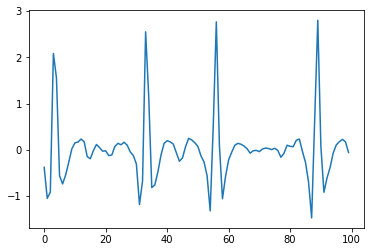

In [28]:
plt.plot(ecg.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())

In [29]:
h0 = encoder.init_hidden(1)
c0 = encoder.init_cell(1)

In [30]:
hidden, cell = encoder(ecg, h0, c0)

In [31]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dense_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, output_size]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #print(input.shape)
        
        #input = [1, batch size, output_size]
                
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.dense_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [32]:
decoder = Decoder(12, 12, 16, 2, 0.01)

In [33]:
pred, hidden2, cell2 = decoder(ecg[0], hidden, cell)

In [34]:
pred

tensor([[ 0.0304,  0.1196, -0.0448,  0.1398,  0.0378, -0.2407,  0.0394, -0.2496,
          0.2394, -0.1683, -0.1365,  0.0198]], grad_fn=<AddmmBackward>)

In [35]:
import random

In [45]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder,  device):
        super().__init__()
        
        self.SOS = 2
        
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device
        self.sigmoid = nn.Sigmoid()
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, tf_ration = 0.3):
        
        #src = [src seq len, batch size, input dim]
        #trg = [trg seq len, batch size, output dim]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        src = src.to(self.device)
        trg = trg.to(self.device)
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        
        #encoder init states
        h0 = encoder.init_hidden(batch_size).to(self.device)
        c0 = encoder.init_cell(batch_size).to(self.device)
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, self.decoder.output_dim).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src, h0, c0)
        
        #first input to the decoder is the <sos> tokens
        input = torch.zeros(batch_size, self.decoder.input_dim, device = self.device, dtype = torch.float32)
        
        for t in range(0, max_len):
        
            use_tf = random.random() < tf_ration
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            
            input = trg[t] if use_tf else output.clone().detach()
            
        
        return outputs

In [46]:
seq2seq = Seq2Seq(encoder, decoder, "cpu")

In [ ]:
pred = seq2seq(ecg, ecg)

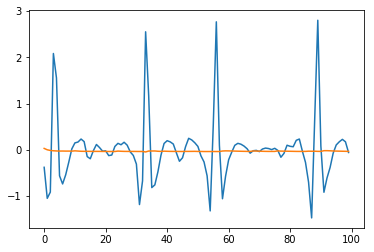

In [39]:
plt.plot(ecg.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())
plt.plot(pred.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())

In [40]:
encoder = Encoder(12, 128, 4, 0.01)
decoder = Decoder(12, 12, 128, 4 , 0.01)
model = Seq2Seq(encoder, decoder, device)

In [41]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [42]:
def train(model, dataset, n_epoch, optimizer, criterion, print_every = 100, plot_every = 300, tfr = 0.3):
    model.train()
    total_step = len(train_loader)
    for epoch in range(n_epoch):
        epoch_loss = 0
        

        for i, (ecg, labels, label_idx) in enumerate(train_loader):
            
            src = ecg.to(device).float()
            trg = ecg.to(device).float()
            
            
            #src = F.avg_pool1d(src, 10)
            #trg = F.avg_pool1d(trg, 10)
            
            
            src = src.transpose(1,2).transpose(0,1)
            trg = trg.transpose(1,2).transpose(0,1)
            

            optimizer.zero_grad()

            output = model(src, trg, tfr)

            loss = criterion(output, trg )
            if (torch.isnan(loss).item()  == 1):
                print("NAN loss")
                print(src)
                print(trg)
                print(pred)
                return

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i % print_every == 0):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epoch, i+1, total_step, loss.item()))
                
            if (i % plot_every == 0):
                plt.plot(src.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())
                plt.plot(output.detach().transpose(0, 1)[0].transpose(0, 1)[0].cpu().numpy())
                plt.show()

In [43]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Epoch [1/40], Step [1/10], Loss: 0.9469


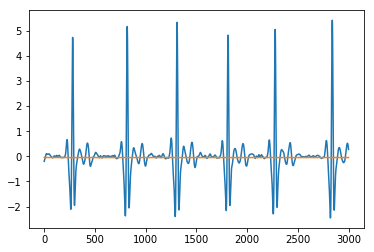

Epoch [1/40], Step [3/10], Loss: 0.9443
Epoch [1/40], Step [5/10], Loss: 1.0526
Epoch [1/40], Step [7/10], Loss: 1.1281
Epoch [1/40], Step [9/10], Loss: 0.9256


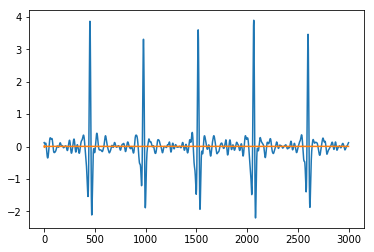

Epoch [2/40], Step [1/10], Loss: 1.0315


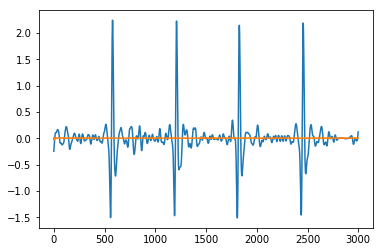

Epoch [2/40], Step [3/10], Loss: 0.9688
Epoch [2/40], Step [5/10], Loss: 1.0598
Epoch [2/40], Step [7/10], Loss: 0.8573
Epoch [2/40], Step [9/10], Loss: 1.1001


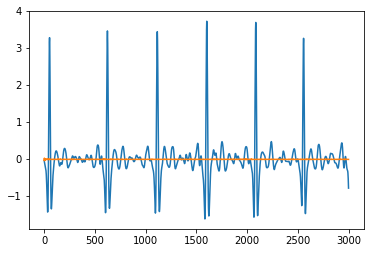

Epoch [3/40], Step [1/10], Loss: 1.0243


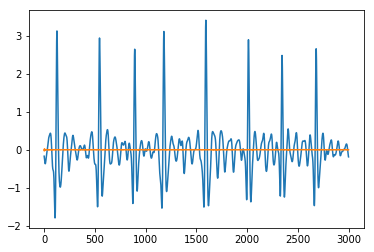

Epoch [3/40], Step [3/10], Loss: 0.9197
Epoch [3/40], Step [5/10], Loss: 1.0239
Epoch [3/40], Step [7/10], Loss: 0.9056
Epoch [3/40], Step [9/10], Loss: 1.0131


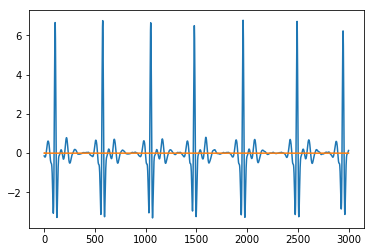

Epoch [4/40], Step [1/10], Loss: 1.0973


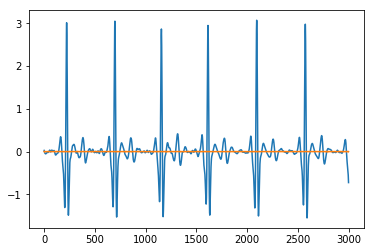

Epoch [4/40], Step [3/10], Loss: 1.1922
Epoch [4/40], Step [5/10], Loss: 1.0080
Epoch [4/40], Step [7/10], Loss: 1.0103
Epoch [4/40], Step [9/10], Loss: 0.9231


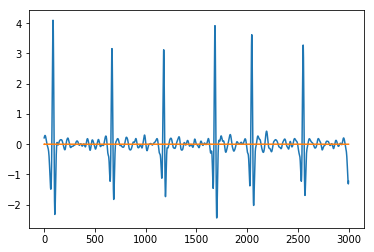

Epoch [5/40], Step [1/10], Loss: 0.8916


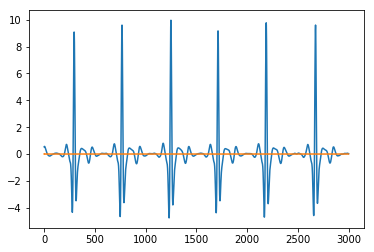

Epoch [5/40], Step [3/10], Loss: 1.0957
Epoch [5/40], Step [5/10], Loss: 0.9454
Epoch [5/40], Step [7/10], Loss: 1.0475
Epoch [5/40], Step [9/10], Loss: 0.9558


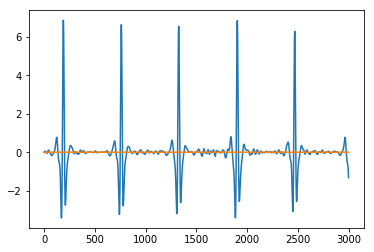

Epoch [6/40], Step [1/10], Loss: 0.9812


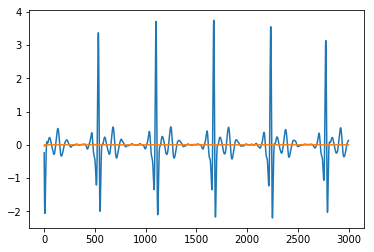

Epoch [6/40], Step [3/10], Loss: 1.1796
Epoch [6/40], Step [5/10], Loss: 1.0011
Epoch [6/40], Step [7/10], Loss: 0.9987
Epoch [6/40], Step [9/10], Loss: 0.9086


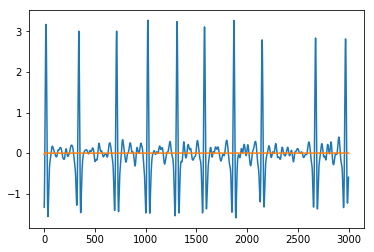

Epoch [7/40], Step [1/10], Loss: 0.9348


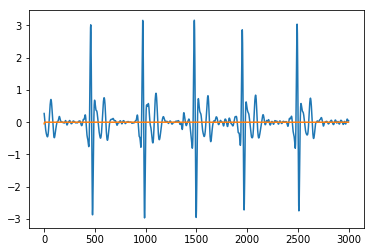

Epoch [7/40], Step [3/10], Loss: 1.0747
Epoch [7/40], Step [5/10], Loss: 0.8805
Epoch [7/40], Step [7/10], Loss: 0.9855
Epoch [7/40], Step [9/10], Loss: 1.0513


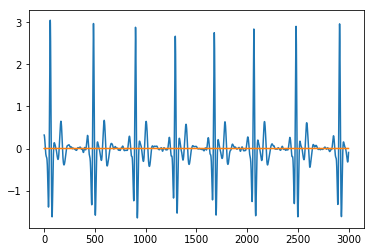

Epoch [8/40], Step [1/10], Loss: 1.0349


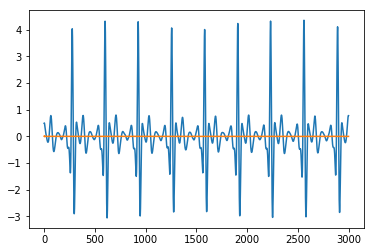

Epoch [8/40], Step [3/10], Loss: 1.0078
Epoch [8/40], Step [5/10], Loss: 0.9935
Epoch [8/40], Step [7/10], Loss: 0.8787
Epoch [8/40], Step [9/10], Loss: 1.0632


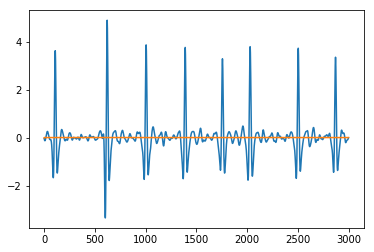

Epoch [9/40], Step [1/10], Loss: 1.0757


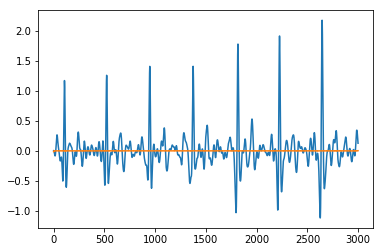

Epoch [9/40], Step [3/10], Loss: 0.9040
Epoch [9/40], Step [5/10], Loss: 0.7985
Epoch [9/40], Step [7/10], Loss: 1.0359
Epoch [9/40], Step [9/10], Loss: 1.0343


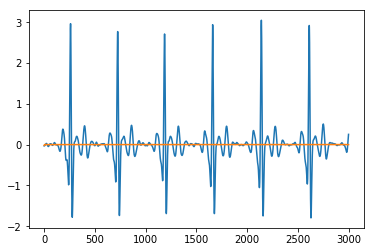

Epoch [10/40], Step [1/10], Loss: 0.9046


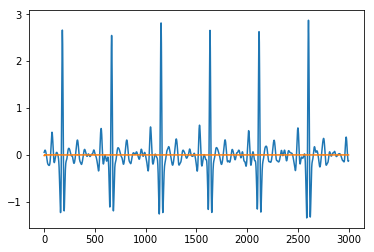

Epoch [10/40], Step [3/10], Loss: 1.0041
Epoch [10/40], Step [5/10], Loss: 0.9531
Epoch [10/40], Step [7/10], Loss: 0.9790
Epoch [10/40], Step [9/10], Loss: 1.1573


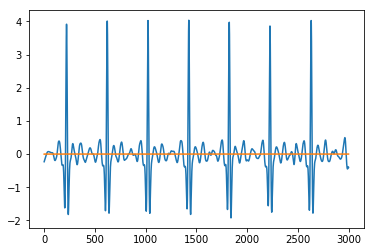

Epoch [11/40], Step [1/10], Loss: 0.8933


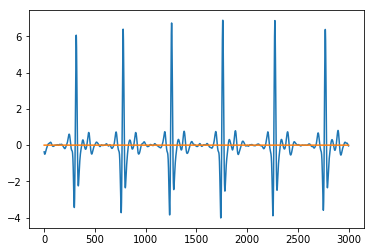

Epoch [11/40], Step [3/10], Loss: 1.0389
Epoch [11/40], Step [5/10], Loss: 0.9187
Epoch [11/40], Step [7/10], Loss: 0.9810
Epoch [11/40], Step [9/10], Loss: 0.9370


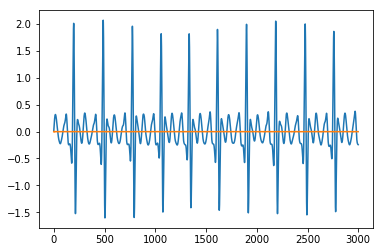

Epoch [12/40], Step [1/10], Loss: 0.9944


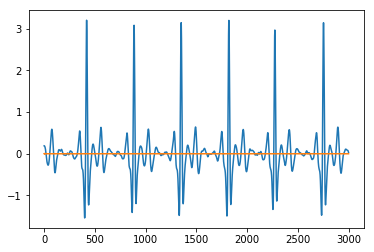

Epoch [12/40], Step [3/10], Loss: 1.0205
Epoch [12/40], Step [5/10], Loss: 1.0290
Epoch [12/40], Step [7/10], Loss: 0.8349
Epoch [12/40], Step [9/10], Loss: 0.9631


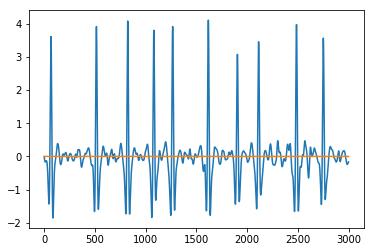

Epoch [13/40], Step [1/10], Loss: 0.9064


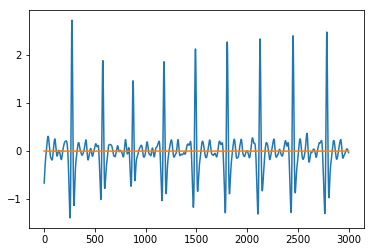

Epoch [13/40], Step [3/10], Loss: 0.9292
Epoch [13/40], Step [5/10], Loss: 0.9562
Epoch [13/40], Step [7/10], Loss: 1.1154
Epoch [13/40], Step [9/10], Loss: 1.0510


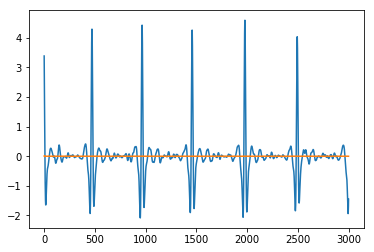

Epoch [14/40], Step [1/10], Loss: 1.0527


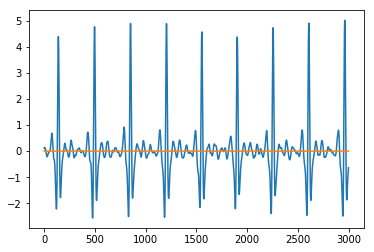

Epoch [14/40], Step [3/10], Loss: 0.9839
Epoch [14/40], Step [5/10], Loss: 1.0109
Epoch [14/40], Step [7/10], Loss: 0.9298
Epoch [14/40], Step [9/10], Loss: 0.8458


KeyboardInterrupt: 

In [44]:
train(model, train_dataset, 40, optimizer, criterion, print_every=2, plot_every = 9, tfr = 0.00)

In [ ]:
test_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
def eval(model, criterion, plot_every):
    model.eval()
    total_step = len(test_loader)
        
    for i, (ecg, labels, label_idx) in enumerate(test_loader):

        src = ecg.to(device).transpose(0, 1).float()
        trg = ecg.to(device).transpose(0, 1).float()

        output = model(src, trg, 0.0)

        loss = criterion(output, trg )

        print ('Step [{}/{}], Loss: {:.4f}' 
               .format(i+1, total_step, loss.item()))

        if (i % plot_every == 0):
            for led in range (12):
                plt.plot(src.detach().transpose(0, 1)[0].transpose(0, 1)[led].cpu().numpy())
                plt.plot(output.detach().transpose(0, 1)[0].transpose(0, 1)[led].cpu().numpy())
                plt.show()